In [3]:
import pandas as pd
import numpy as np


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16

In [5]:
import os
training_dir = 'archive/EuroSAT/'
print(os.listdir(training_dir))

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest',
    validation_split=0.2)


train_data = train_datagen.flow_from_directory(
    training_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training')

val_data = train_datagen.flow_from_directory(
    training_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation')




Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [7]:
print(train_data.class_indices)


{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model1 = Sequential(
    [
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10,activation='softmax')    #10 nodes/neurons because there are 10 classes
    ]
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])



In [ ]:
history1 = model1.fit(
    train_data,epochs=10,validation_data=val_data,
    # class_weight=dict(enumerate(compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=train_data.classes)))
)

In [9]:
model1.evaluate(val_data)

169/169 [==============================] - 16s 94ms/step - loss: 0.6070 - accuracy: 0.8069


[0.607012152671814, 0.806851863861084]

In [11]:
from tensorflow.keras.preprocessing import image
import numpy as np  
image_path = r"general\resid.webp"
img = image.load_img(image_path,target_size=(64,64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array,axis=0)
img_array = img_array/255.0
predictions = model1.predict(img_array)
print(predictions)
print("Predicted class is: ",np.argmax(predictions))



1/1 [==============================] - 0s 136ms/step
[[4.01536804e-09 1.13982274e-07 2.35539977e-03 1.43742282e-03
  1.56236542e-02 8.00058046e-08 8.41012661e-05 9.80481207e-01
  1.79352119e-05 1.78550938e-10]]
Predicted class is:  7


In [12]:
label_map = {
    "AnnualCrop": 0,
    "Forest": 1,
    "HerbaceousVegetation": 2,
    "Highway": 3,
    "Industrial": 4,
    "Pasture": 5,
    "PermanentCrop": 6,
    "Residential": 7,
    "River": 8,
    "SeaLake": 9
}

In [13]:
class_name = list(label_map.keys())[list(label_map.values()).index(np.argmax(predictions))]
print(f'Predicted class: {class_name}')


Predicted class: Residential


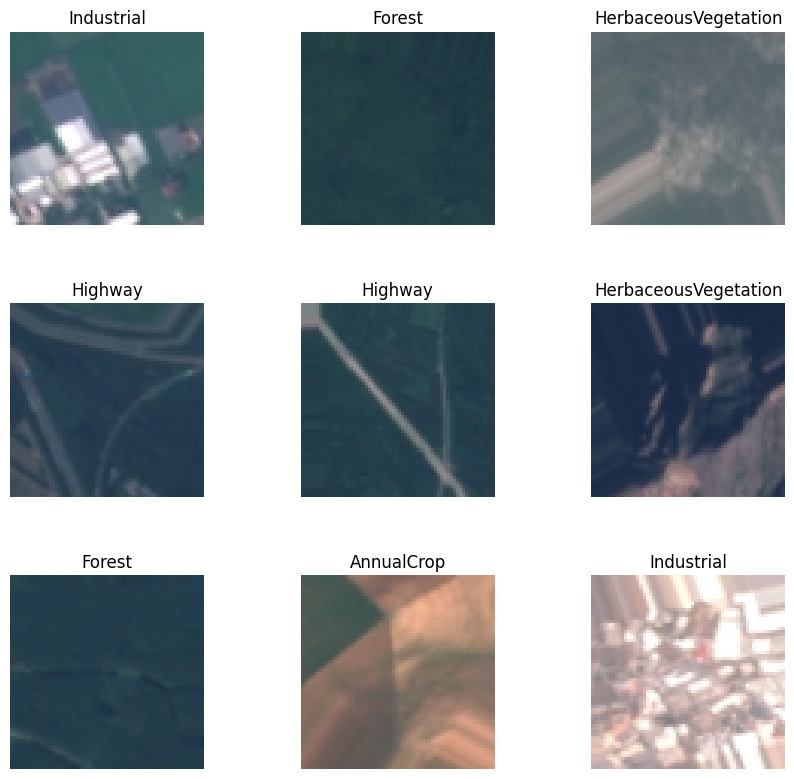

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

#firstly we will visualize the sample images
def visualize_sample_images(train_data):
    class_names = list(train_data.class_indices.keys())
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in np.arange(0, 9):
        batch = next(train_data)
        img = batch[0][0]
        label = np.argmax(batch[1][0])
        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()

visualize_sample_images(train_data)




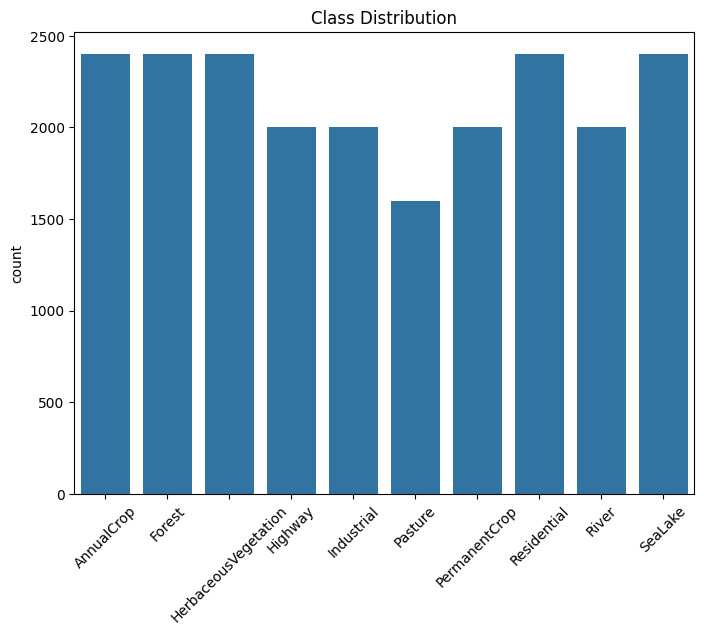

In [15]:
#visualizing the class distribution
def plot_class_distribution(train_data):
    class_labels = list(train_data.class_indices.keys())
    class_counts = train_data.classes
    plt.figure(figsize=(8, 6))
    sns.countplot(x=class_counts)
    plt.title('Class Distribution')
    plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
    plt.show()

plot_class_distribution(train_data)


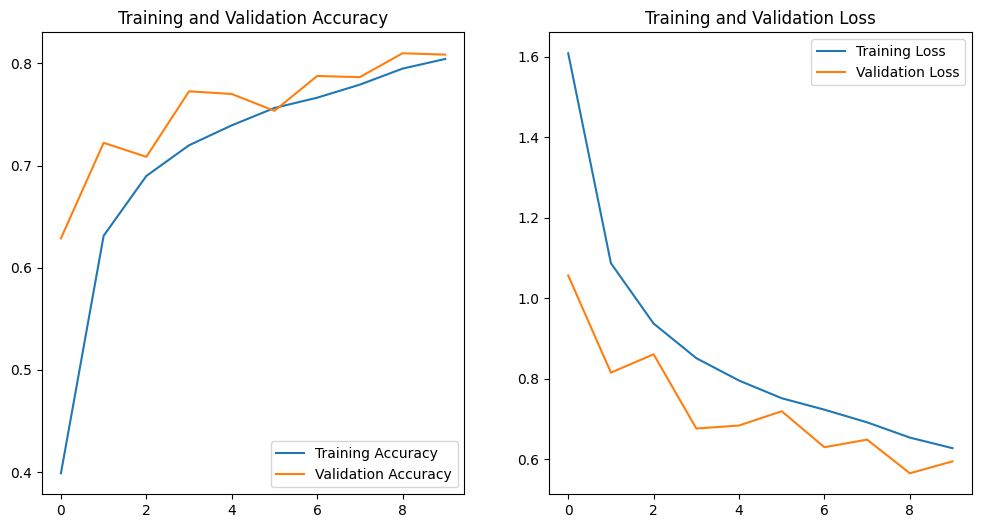

In [16]:
#accuracy plot
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

  
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history1)

169/169 [==============================] - 10s 60ms/step


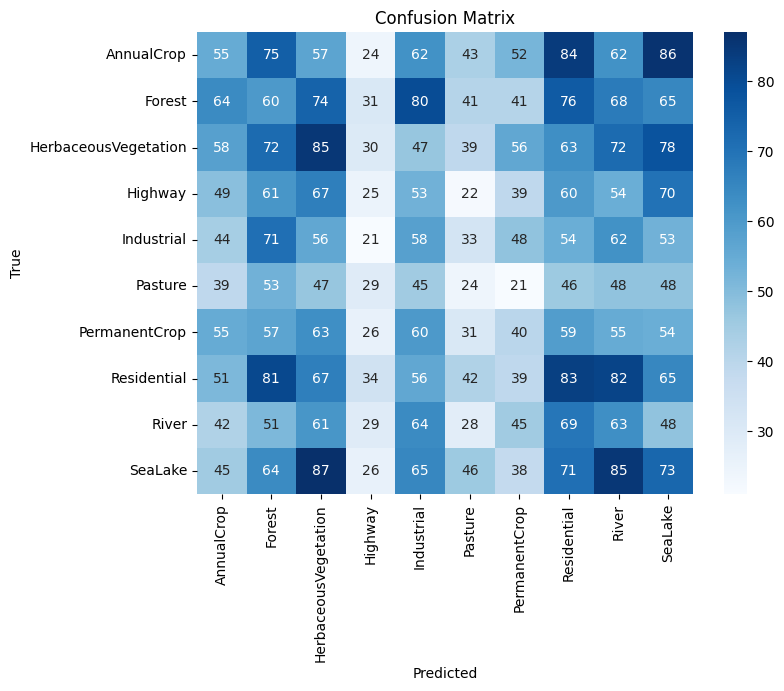

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.11      0.09      0.10       600
              Forest       0.09      0.10      0.10       600
HerbaceousVegetation       0.13      0.14      0.13       600
             Highway       0.09      0.05      0.06       500
          Industrial       0.10      0.12      0.11       500
             Pasture       0.07      0.06      0.06       400
       PermanentCrop       0.10      0.08      0.09       500
         Residential       0.12      0.14      0.13       600
               River       0.10      0.13      0.11       500
             SeaLake       0.11      0.12      0.12       600

            accuracy                           0.10      5400
           macro avg       0.10      0.10      0.10      5400
        weighted avg       0.10      0.10      0.10      5400



In [17]:
#confusion matrix and classification report for accuracy check:
val_data.reset()
y_pred = model1.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.class_indices.keys(),
            yticklabels=train_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=train_data.class_indices.keys()))

In [18]:
from keras.applications import VGG16
base_model = VGG16(weights='imagenet',include_top=False,input_shape=(64,64,3))

#now freezing the layers of the base model so they don't get trained/updated
for layer in base_model.layers:
    layer.trainable = False



In [19]:
from keras.layers import Input,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Dense,Dropout
input_layer = Input(shape=(64,64,3))
base_ = base_model(input_layer)

#my custom layers
base_ = Conv2D(64,(3,3),activation='relu',padding='same')(base_)
base_ = MaxPooling2D(2,2,padding='same')(base_)
base_ = Conv2D(128,(3,3),activation='relu',padding='same')(base_)
base_ = MaxPooling2D(2,2,padding='same')(base_)
base_ = Conv2D(128,(3,3),activation='relu',padding='same')(base_)

base_ = GlobalAveragePooling2D()(base_)

base_ = Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(base_)
base_ = Dropout(0.5)(base_)

output = Dense(10,activation='softmax')(base_)
model2 = keras.Model(inputs=input_layer,outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])



In [20]:
history2 = model2.fit(train_data,epochs=10,validation_data=val_data)

Epoch 1/10
675/675 [==============================] - 307s 453ms/step - loss: 1.1587 - accuracy: 0.5961 - val_loss: 0.8493 - val_accuracy: 0.7102
Epoch 2/10
675/675 [==============================] - 236s 350ms/step - loss: 0.7851 - accuracy: 0.7498 - val_loss: 0.6961 - val_accuracy: 0.7730
Epoch 3/10
675/675 [==============================] - 231s 343ms/step - loss: 0.7119 - accuracy: 0.7781 - val_loss: 0.6757 - val_accuracy: 0.7761
Epoch 4/10
675/675 [==============================] - 295s 437ms/step - loss: 0.6640 - accuracy: 0.7871 - val_loss: 0.6182 - val_accuracy: 0.7961
Epoch 5/10
675/675 [==============================] - 254s 377ms/step - loss: 0.6347 - accuracy: 0.7975 - val_loss: 0.5852 - val_accuracy: 0.8059
Epoch 6/10
675/675 [==============================] - 234s 346ms/step - loss: 0.6174 - accuracy: 0.8012 - val_loss: 0.5681 - val_accuracy: 0.8159
Epoch 7/10
675/675 [==============================] - 232s 344ms/step - loss: 0.5768 - accuracy: 0.8158 - val_loss: 0.5566 -

In [21]:
model2.evaluate(val_data)

169/169 [==============================] - 37s 218ms/step - loss: 0.5182 - accuracy: 0.8281


[0.518154501914978, 0.8281481266021729]

In [24]:
image_path2 = r"general\zambezi_oli_2013241.webp"
img2 = image.load_img(image_path2,target_size=(64,64))
img_array2 = image.img_to_array(img2)
img_array2 = np.expand_dims(img_array2,axis=0)
img_array2 = img_array2/255.0
predictions2 = model2.predict(img_array2)
print(predictions2)
print("Predicted class is: ",np.argmax(predictions2))

class_name2 = list(label_map.keys())[list(label_map.values()).index(np.argmax(predictions2))]
print(f'Predicted class: {class_name2}')


1/1 [==============================] - 0s 49ms/step
[[3.0673094e-04 1.0494598e-06 6.5769946e-06 5.6227413e-03 2.3148802e-06
  5.3946449e-05 2.5045214e-05 7.2114085e-07 9.9397558e-01 5.1882053e-06]]
Predicted class is:  8
Predicted class: River


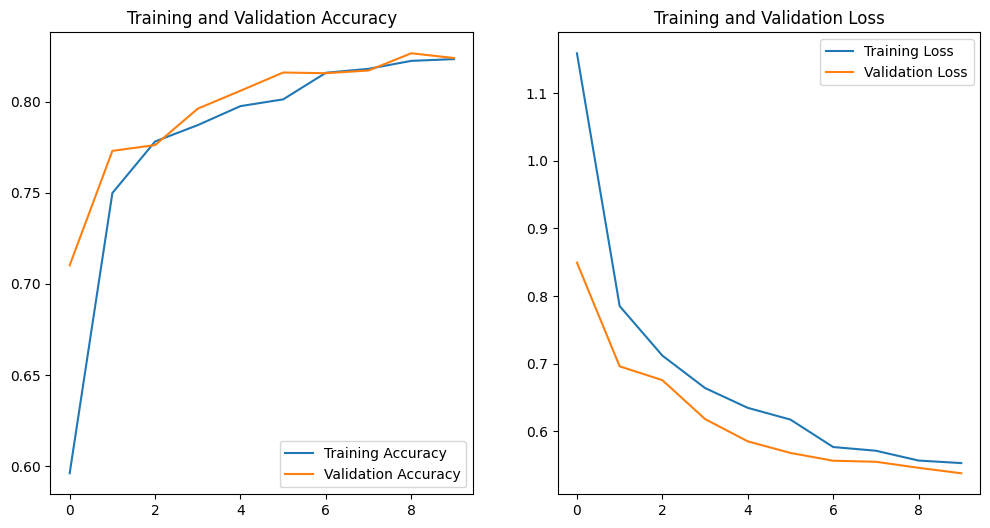

In [25]:
#accuracy plot
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

 
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history2)

169/169 [==============================] - 38s 225ms/step


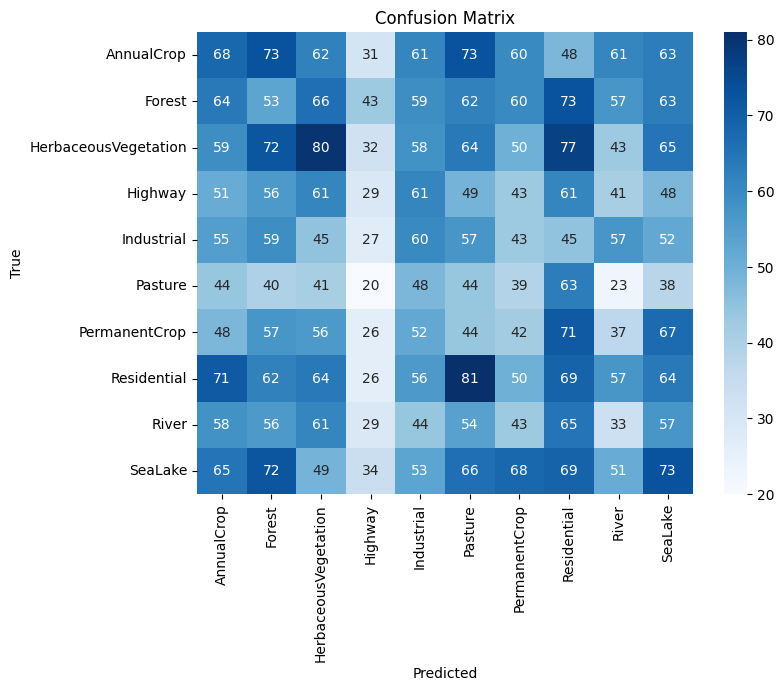

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.12      0.11      0.11       600
              Forest       0.09      0.09      0.09       600
HerbaceousVegetation       0.14      0.13      0.14       600
             Highway       0.10      0.06      0.07       500
          Industrial       0.11      0.12      0.11       500
             Pasture       0.07      0.11      0.09       400
       PermanentCrop       0.08      0.08      0.08       500
         Residential       0.11      0.12      0.11       600
               River       0.07      0.07      0.07       500
             SeaLake       0.12      0.12      0.12       600

            accuracy                           0.10      5400
           macro avg       0.10      0.10      0.10      5400
        weighted avg       0.10      0.10      0.10      5400



In [26]:
#confusion matrix and classification report for accuracy check:
val_data.reset()
y_pred = model2.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.class_indices.keys(),
            yticklabels=train_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=train_data.class_indices.keys()))